In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import scipy.io
import pandas as pd
import numpy as np
from scipy.io import loadmat
from pathlib import Path
import math
from scipy.misc import derivative
from scipy import signal
#from visualization import TrajectcoryVisualize


rcParams.update({'font.size': 18})

In [2]:
class ReadMat:
    def __init__(self,filename):
        self.input_file = filename
        self.all_data= loadmat(self.input_file)

        self.raw_data= self.all_data['yout']
        self.params= self.all_data['tgParams']

    def positions(self):
        return np.array([self.raw_data[:,10], self.raw_data[:,11], self.raw_data[:,12]])

    def angles(self):
        q0 = np.array(self.raw_data[:,13])
        q1 = np.array(self.raw_data[:,14])
        q2 = np.array(self.raw_data[:,15])
        q3 = np.array(self.raw_data[:,16])
        roll= np.zeros((q0.shape))
        pitch = np.zeros((q0.shape))
        yaw = np.zeros((q0.shape))
        a=0
        for i,j,k,l in zip(q0,q1,q2,q3):

            roll[a]= math.atan2 ( 2*(i*j + k*l), 1-2*(j**2 + k**2))
            val= 2 * (i * k - l * j)
            if abs(val)>=1:
                pitch[a]= math.copysign(math.pi/2,val)
            else:
                pitch[a] = math.asin(val)
            yaw[a] = math.atan2 (2*(i*l + j*k ),1-2*(k**2+l**2))
            a+=1
        return roll, pitch, yaw
    
    def vel(self,xpos,ypos,zpos):
        sampling_rate= xpos.shape[0]
        cut_off_frequency= 240/10*2*np.pi/(sampling_rate/2) #0.054 HZ
        b,a= signal.butter (3, cut_off_frequency) #third order butterworth filter with cutoff frequency given above
        filtered_xpos =signal.filtfilt(b,a,xpos)
        filtered_ypos =signal.filtfilt(b,a,ypos)
        filtered_zpos =signal.filtfilt(b,a,zpos)
        xvel= np.gradient(filtered_xpos)
        yvel= np.gradient(filtered_ypos)
        zvel= np.gradient(filtered_zpos)
        omega1= self.raw_data[:,17]
        omega2= self.raw_data[:,18]
        omega3= self.raw_data[:,19]

        return xvel, yvel, zvel, omega1, omega2, omega3

    def get_states(self):
        roll, pitch, yaw = self.angles()
        xpos, ypos, zpos= self.positions()
        xvel,yvel,zvel, omega1,omega2,omega3 = self.vel(xpos, ypos, zpos)
        return np.array([xpos, ypos, zpos, xvel,yvel,zvel, roll, pitch, yaw, omega1,omega2,omega3])

    def get_actions(self):
        initial_amplitude= (self.params[0][0][5][0][0][2]).item()
        Z_param= self.raw_data[:,6]-initial_amplitude
        roll_param= self.raw_data[:,7]
        pitch_param= self.raw_data[:,8]
        return np.array([Z_param, roll_param, pitch_param])
    
    def sampled_mocap_data(self, samples_steps):
        states_trajectory= self.get_states() # number of state X number of training examples
        action_trajectory= self.get_actions() # number of actions X number of training examples
        new_action_trajectory= np.zeros((action_trajectory.shape[0],int(action_trajectory.shape[1]/samples_steps)))
        new_trajectory= np.zeros((states_trajectory.shape[0],int(states_trajectory.shape[1]/samples_steps)))
        for i in range(int(states_trajectory.shape[1]/samples_steps)):
            new_trajectory[:,i] =np.sum(states_trajectory[:,i*samples_steps:(i+1)*samples_steps],axis=1)/samples_steps
            new_action_trajectory[:,i] =np.sum(action_trajectory[:,i*samples_steps:(i+1)*samples_steps],axis=1)/samples_steps

        return new_trajectory,new_action_trajectory

In [4]:
def DMD(X,Xprime,r):
    ''' This function computes the linear approximation to a nonlinear dynamical system whose state 
    recordings are passed in.
    
    Arguments:
    
    Input:
    
        X: The states of the system
        
        Xprime: the rate of change of the states obtained form finite differencing or direct measurement
        
        r: the rank of the low-rank approximation
        
    Output:
    
        Phi: State transition matrix
        
        Lambda: Eigenvalues of Atilde
        
        b: Amplitude of the modes
    '''
    # obtain singular value decompositon matrices truncated to order r
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    # Obtain the reduced order system matrix,i.e, A matrix 
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    
    # Obtain the eiegnvales and eigenvectors of the system matrix
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    # obtain the state transition matrix for the discrete time linear approximation and also 'b' which helps 
    # reconstruct time dynamics
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

In [54]:
def DMDc(X,Xprime,Upsilon,r,B = np.zeros((1,1))):
    ''' This function computes the linear approximation to a controlled nonlinear dynamical system whose state 
    recordings and control inputs are passed in.
    
    Arguments:
    
    Input:
    
        X: The states of the system
        
        Xprime: the rate of change of the states obtained form finite differencing or direct measurement
        
        Upsilon: The control action data
        
        B: The matrix that dicstates how the control actions affect the system, if available
        
        r: the rank of the low-rank approximation
        
    Output:
    
        Phi: State transition matrix
        
        Lambda: Eigenvalues of Atilde
        
        b: Amplitude of the modes
    '''
    # if B is unkown
    if((B == np.zeros((1,1))).all()):
        print("not done yet")
        return 0
        
    # if B is known
    else : 
        Xprime = Xprime-B@Upsilon
        return DMD(X,Xprime,r)

In [55]:
data_path = '../Raw_data/8_8_2019 to 8_12_2019/'
file1 = '2019-08-08-19-16-02_5sec.mat'
file2 = '2019-08-09-12-49-56_7sec.mat'
file3 = '2019-08-09-13-01-42_10sec.mat'

file_to_open1 = data_path+file1
file_to_open2 = data_path+file2
file_to_open3 = data_path+file3

object1 = ReadMat(file_to_open1)

sampling = 100
# dataset 1
state_traj1, action_traj1 = object1.sampled_mocap_data(sampling)
state_traj1 = state_traj1[:,:500]
action_traj1 = action_traj1[:,:500]

object2 = ReadMat(file_to_open2)
# dataset 2
state_traj2, action_traj2 = object2.sampled_mocap_data(sampling)
state_traj2 = state_traj2[:,:700]
action_traj2 = action_traj2[:,:700]

object3 = ReadMat(file_to_open3)
# dataset 3
state_traj3, action_traj3 = object3.sampled_mocap_data(sampling)
state_traj3 = state_traj3[:,:1000]
action_traj3 = action_traj3[:,:1000]

## Given 
$$\dot{x} = f(x,u)$$ 
## or 
$$\dot{x} = f(x) + g(x)u$$ 
## We need to find 
$$\dot{x} = Ax+Bu$$

$x = \begin{bmatrix} x \\
y \\
z \\
\dot{x} \\
\dot{y} \\
\dot{z} \\
\theta_x \\
\theta_y \\
\theta_z \\
\omega_x \\
\omega_y \\
\omega_z \\
\end{bmatrix}$
&emsp;  &emsp; &emsp; 
$\dot{x} = \begin{bmatrix} \dot{x} \\
\dot{y} \\
\dot{z} \\
\ddot{x} \\
\ddot{y} \\
\ddot{z} \\
\dot{\theta}_x \\
\dot{\theta}_y \\
\dot{\theta}_z \\
\dot{\omega}_x \\
\dot{\omega}_y \\
\dot{\omega}_z \\
\end{bmatrix}$
&emsp;  &emsp; &emsp;
$A_{12 \times 12} = ?$
&emsp;  &emsp; &emsp;
$B_{12 \times 3} = \begin{bmatrix}
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
1 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1\\
0 & 0 & 0\\
\end{bmatrix}$
&emsp;  &emsp; &emsp;
$u = \begin{bmatrix}
u_{zaccel} \\
u_{roll} \\
u_{pitch}
\end{bmatrix}
$



## Assuming B is known

In [89]:
X = state_traj3[:,0:-1]
Xprime = state_traj3[:,1:]

Upsilon = action_traj3[:,0:-1] 

Omega = np.vstack([X,Upsilon])

# define the B matrix
B_sys = np.zeros((12,3))
B_sys[5,0]  = 1
B_sys[9,1] = 1
B_sys[10,2] = 1

r = 12 # number of states
dt = 0.01 # in seconds

In [90]:
Phi, Lambda, b = DMDc(X,Xprime,Upsilon,r, B_sys)
omega = np.log(np.diag(Lambda))/dt

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]


In [98]:
# reconstruct dynamics with DMD as a sanity check
start_time = 0
end_time = X.shape[1]*dt
time = np.arange(start_time,end_time,dt) # time vector

time_dynamics = np.zeros([Phi.shape[1],len(time)])

for i in range(time_dynamics.shape[1]):
    time_dynamics[:,i] = b*np.exp(omega*time[i])
    
X_dmd = np.dot(Phi,time_dynamics)

print(X_dmd.shape)

(12, 999)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


/home/ashwin/.local/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


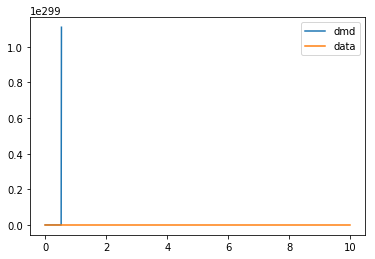

In [99]:
plt.plot(time,X_dmd[2,:],label='dmd')
plt.plot(time,X[2,:],label='data')
plt.legend()

## Assuming B is unknown

In [83]:
X.shape

(12, 999)